# Kernel-based Time-varying Regression - Part IV

We will continue to cover advance inputs for KTR. For other details you can also refer to the original paper Ng, Wang and Dai (2021).

In **Part IV**, we will cover advance inputs for regression including

- regressors signs
- time-point coefficients priors 

In [1]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTR
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.plot import get_orbit_style
from orbit.utils.kernels import gauss_kernel

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)
orbit_style = get_orbit_style()
plt.style.context(orbit_style);

## Data

To demo the effect of specifying regressors coefficients sign, we customize the data generation a bit in order to impose strictly positive regression coefficients. Here, we approximate the coefficient curves with **Gaussian kernel** with some positive values of knots. Levels are also included in the process with vector of ones as the covariates. 

We have a few parameters here to set up the data simulation:

- `n` : number of time steps
- `p` : number of predictors

In [2]:
np.random.seed(2021)

n = 300
p = 2
tp = np.arange(1, 301) / 300
knot_tp = np.array([1, 100, 200, 300]) / 300
beta_knot = np.array(
    [[1.0, 0.1, 0.15],
     [3.0, 0.01, 0.05],
     [3.0, 0.01, 0.05],
     [2.0, 0.05, 0.02]]
)

gk = gauss_kernel(tp, knot_tp, rho=0.2)
beta = np.matmul(gk, beta_knot)
covar_lev = np.ones((n, 1))
covar = np.concatenate((covar_lev, np.random.normal(0, 1.0, (n, p))), axis=1)\

# observation with noise
y = (covar * beta).sum(-1) + np.random.normal(0, 0.1, n)


regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]
data = pd.DataFrame(covar[:,1:], columns=regressor_col)
data['y'] = y
data['date'] = pd.date_range(start='1/1/2018', periods=len(y))
data = data[['date', 'y'] + regressor_col]
beta_col = ['beta{}'.format(pp) for pp in range(1, p+1)]
beta_data = pd.DataFrame(beta[:,1:], columns=beta_col)

data = pd.concat([data, beta_data], axis=1)

In [3]:
data.tail(10)

,date,y,x1,x2,beta1,beta2
290,2018-10-18,2.15947,-0.62762,0.17840,0.04015,0.02739
291,2018-10-19,2.25871,-0.92975,0.81415,0.04036,0.02723
292,2018-10-20,2.18356,0.82438,-0.92705,0.04057,0.02707
293,2018-10-21,2.26948,1.57181,-0.78098,0.04077,0.02692
294,2018-10-22,2.26375,-1.07504,-0.86523,0.04097,0.02677
295,2018-10-23,2.21349,0.24637,-0.98398,0.04117,0.02663
296,2018-10-24,2.13297,-0.58716,0.59911,0.04136,0.02648
297,2018-10-25,2.00949,-2.01610,0.08618,0.04155,0.02634
298,2018-10-26,2.14302,0.33863,-0.37912,0.04173,0.02620
299,2018-10-27,2.10795,-0.96160,-0.42383,0.04192,0.02606


Just like previous tutorials in regression, we supply some additional args to describe the regressors and the scale parameters for knots which approximates the coefficients curves.

In [4]:
ktr = KTR(
    response_col='y',
    date_col='date',
    regressor_col=regressor_col,
    regressor_init_knot_scale=[0.1] * p,
    regressor_knot_scale=[0.1] * p,
    prediction_percentiles=[2.5, 97.5],
    seed=2021,
    estimator='pyro-svi',
)
ktr.fit(df=data)

INFO:root:Guessed max_plate_nesting = 1


## Visualization of Regression Coefficient Curves

Again, we leverage `get_regression_coefs` to extract coefficients with intervals by supplying argument `include_ci=True`.

In [5]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True)

With the overlay the estimate on the true coefficients, we can see the coefficients cover some negative ranges.

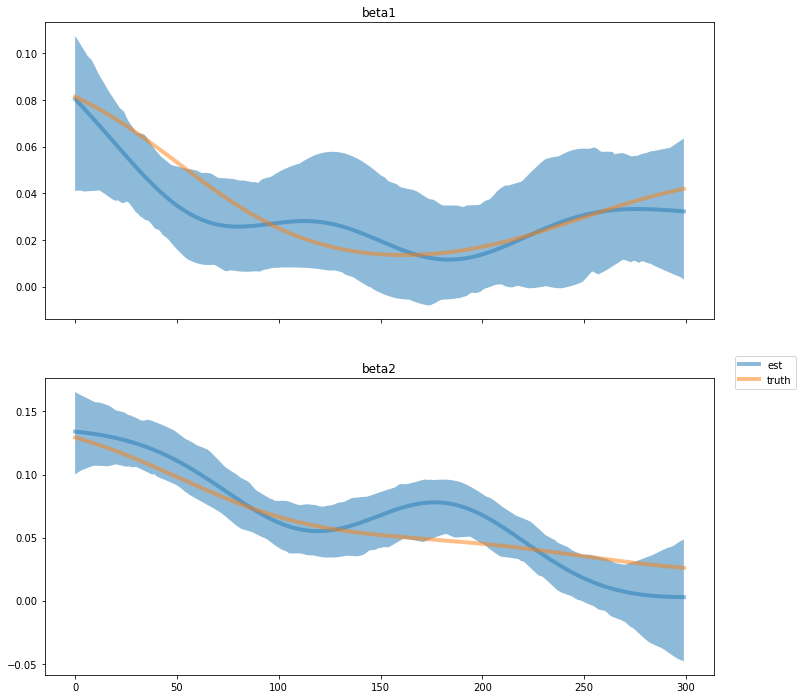

In [6]:
fig, axes = plt.subplots(p, 1, figsize=(12, 12), sharex=True)

x = np.arange(coef_mid.shape[0])
for idx in range(p):
    axes[idx].plot(x, coef_mid['x{}'.format(idx + 1)], label='est' if idx == 0 else "", alpha=0.5, lw=4)
    axes[idx].fill_between(x, coef_lower['x{}'.format(idx + 1)], coef_upper['x{}'.format(idx + 1)], alpha=0.5)
    axes[idx].plot(x, data['beta{}'.format(idx + 1)], label='truth' if idx == 0 else "", alpha=0.5, lw=4)
    axes[idx].set_title('beta{}'.format(idx + 1))

fig.legend(bbox_to_anchor = (1,0.5));

## Regressor Sign

To impose strictly positive coefficients, we can leverage the `regressor_sign` arg by supplying a string of `'+'`.

In [7]:
ktr = KTR(
    response_col='y',
    date_col='date',
    regressor_col=regressor_col,
    regressor_init_knot_scale=[0.1] * p,
    regressor_knot_scale=[0.1] * p,
    regressor_sign=['+'] * p,
    prediction_percentiles=[2.5, 97.5],
    seed=2021,
    estimator='pyro-svi',
)
ktr.fit(df=data)

INFO:root:Guessed max_plate_nesting = 1


In [8]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True)

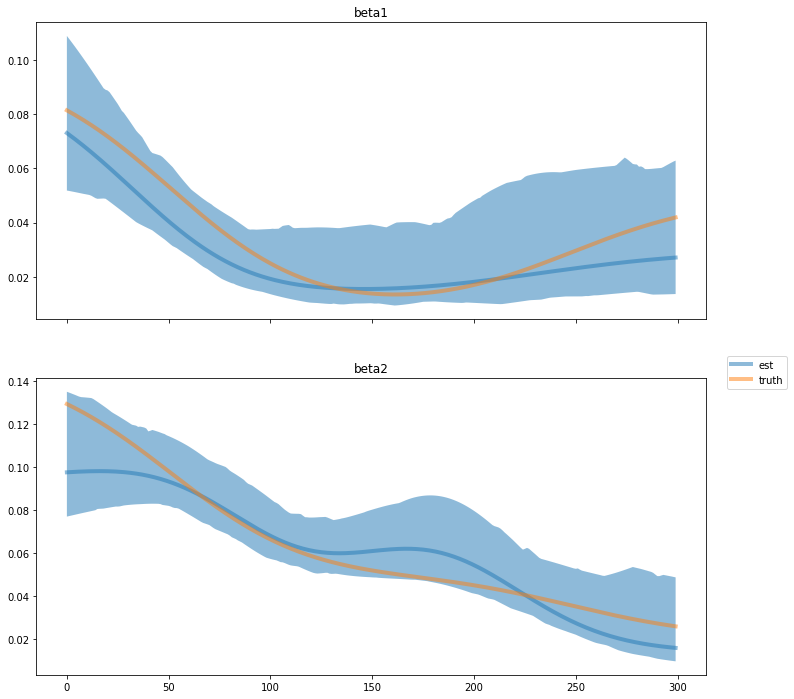

In [9]:
fig, axes = plt.subplots(p, 1, figsize=(12, 12), sharex=True)

x = np.arange(coef_mid.shape[0])
for idx in range(p):
    axes[idx].plot(x, coef_mid['x{}'.format(idx + 1)], label='est' if idx == 0 else "", alpha=0.5, lw=4)
    axes[idx].fill_between(x, coef_lower['x{}'.format(idx + 1)], coef_upper['x{}'.format(idx + 1)], alpha=0.5)
    axes[idx].plot(x, data['beta{}'.format(idx + 1)], label='truth' if idx == 0 else "", alpha=0.5, lw=4)
    axes[idx].set_title('beta{}'.format(idx + 1))

fig.legend(bbox_to_anchor = (1,0.5));

Now, we clearly see that the curves lie on positive range with a slightly better fit.

To conclude, it is useful to have a strictly positive range of regression coefficients if we have prior knowledge. **KTR** allows these priors to be specified.  Of course, for users who are uncertain with the coefficients sign, they are recommended to use the default which contains both sides of the range.  They can also supply a string of `'='` in `regressor_sign` arg.

## Time-point coefficient priors

Users can incorporate coefficient priors for any regressor and any time period. This feature is quite useful when users have some prior knowledge or beliefs on regressor coefficients. For example, if an A/B test is conducted for a certain regressor over a specific time range, then users can ingest the priors derived from such A/B test.

This can be done by supplying a list of dictionaries via `coef_prior_list`. Each dict in the list should have keys as `name`, `prior_start_tp_idx` (inclusive), `prior_end_tp_idx` (not inclusive), `prior_mean`, `prior_sd`, and `prior_regressor_col`.

Below is an illustrative example by using the simulated data above.

In [10]:
from copy import deepcopy

In [11]:
prior_duration = 50
coef_list_dict = []
prior_idx=[
    np.arange(150, 150 + prior_duration), 
    np.arange(200, 200 + prior_duration), 
]
regressor_idx = range(1, p + 1)
plot_dict = {}
for i in regressor_idx:
    plot_dict[i] = {'idx': [], 'val': []}

In [12]:
for idx, idx2, regressor in zip(prior_idx, regressor_idx, regressor_col):
    prior_dict = {}
    prior_dict['name'] = f'prior_{regressor}'
    prior_dict['prior_start_tp_idx'] = idx[0]
    prior_dict['prior_end_tp_idx'] = idx[-1] + 1
    prior_dict['prior_mean'] = beta[idx, idx2]
    prior_dict['prior_sd'] = [0.1] * len(idx)
    prior_dict['prior_regressor_col'] = [regressor] * len(idx)
    
    plot_dict[idx2]['idx'].extend(idx)
    plot_dict[idx2]['val'].extend(beta[idx, idx2])
     
    coef_list_dict.append(deepcopy(prior_dict)) 

In [13]:
ktr = KTR(
    response_col='y',
    date_col='date',
    regressor_col=regressor_col,
    regressor_init_knot_scale=[0.1] * p,
    regressor_knot_scale=[0.1] * p,
    regressor_sign=['+'] * p,
    coef_prior_list = coef_list_dict,
    prediction_percentiles=[2.5, 97.5],
    seed=2021,
    estimator='pyro-svi',
)
ktr.fit(df=data)

INFO:root:Guessed max_plate_nesting = 1


In [14]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True)

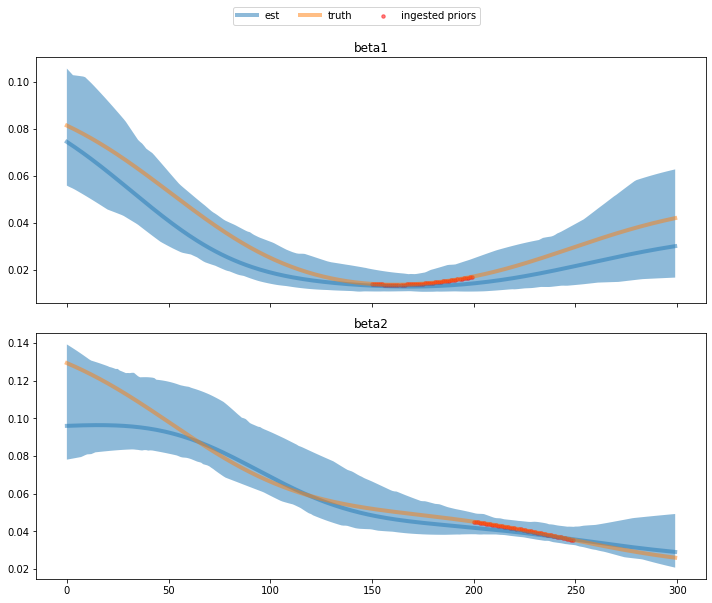

In [15]:
fig, axes = plt.subplots(p, 1, figsize=(10, 8), sharex=True)

x = np.arange(coef_mid.shape[0])
for idx in range(p):
    axes[idx].plot(x, coef_mid['x{}'.format(idx + 1)], label='est', alpha=0.5, lw=4)
    axes[idx].fill_between(x, coef_lower['x{}'.format(idx + 1)], coef_upper['x{}'.format(idx + 1)], alpha=0.5)
    axes[idx].plot(x, data['beta{}'.format(idx + 1)], label='truth', alpha=0.5, lw=4)
    axes[idx].set_title('beta{}'.format(idx + 1))
    axes[idx].scatter(plot_dict[idx + 1]['idx'], plot_dict[idx + 1]['val'],
                      s=12, color='red', alpha=.5, label='ingested priors')
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(.5, 1.05))

plt.tight_layout()

As seen above, for the ingested prior time window, the estimation is aligned better with the truth and the resulting confidence interval also becomes narrower compared to other periods.

## References

1. Ng, Wang and Dai (2021). Bayesian Time Varying Coefficient Model with Applications to Marketing Mix Modeling, arXiv preprint arXiv:2106.03322 